In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [2]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [4]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [5]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [6]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [8]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 0

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')

EPOCHS = 100

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2 * (data.읍면동.nunique()), 62 * (data.읍면동.nunique()) #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 64
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

data = data.sort_values(by = ['일자','읍면동'])
data['일자'] = pd.to_datetime(data['일자'])
data = data.set_index(keys = '일자')
#data = data.loc["2019-11-07":, : ]

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

In [9]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [10]:
data.drop(['읍면동'], axis=1, inplace=True)

In [11]:
train.drop(['읍면동'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
train_data = train[:int(0.80 * (len(train) - (look_back_window + forecast_horizon)))]   #train_data = train[:int(0.6 * len(data))]
val_data = train[int(0.80 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [13]:
train_data.shape, val_data.shape, test_data.shape

((10140, 27), (4147, 27), (2366, 27))

In [14]:
look_back_window + forecast_horizon

2366

In [15]:
# Load and preprocess data
#data = data.set_index(keys = 'base_date')
#data = data.query('emd_nm == 24')

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(7775, 1560, 27), y(7775, 806)


In [16]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1560, 27)]        0         
_________________________________________________________________
sci_net (SciNet)             ((None, 806), (None, 27)) 876835    
Total params: 876,835
Trainable params: 876,835
Non-trainable params: 0
_________________________________________________________________


In [17]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

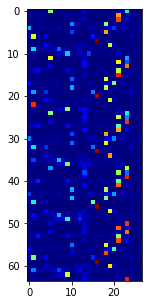

epochs: 1/100, train loss : 0.98278 train mse: 0.98278 train mae: 0.73494  validation loss: 0.77493 validation mse : 0.77493 validation mae: 0.67532
epochs: 2/100, train loss : 0.86351 train mse: 0.74425 train mae: 0.64621  validation loss: 0.68734 validation mse : 0.59975 validation mae: 0.60181
epochs: 3/100, train loss : 0.76990 train mse: 0.58269 train mae: 0.57752  validation loss: 0.62481 validation mse : 0.49976 validation mae: 0.55234
epochs: 4/100, train loss : 0.69658 train mse: 0.47662 train mae: 0.52226  validation loss: 0.57427 validation mse : 0.42263 validation mae: 0.50678
epochs: 5/100, train loss : 0.63809 train mse: 0.40410 train mae: 0.47705  validation loss: 0.53288 validation mse : 0.36734 validation mae: 0.46970
epochs: 6/100, train loss : 0.59157 train mse: 0.35899 train mae: 0.44502  validation loss: 0.50341 validation mse : 0.35605 validation mae: 0.45894
epochs: 7/100, train loss : 0.55206 train mse: 0.31498 train mae: 0.41074  validation loss: 0.47743 valida

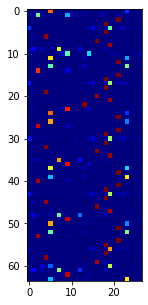

epochs: 11/100, train loss : 0.44404 train mse: 0.22687 train mae: 0.33023  validation loss: 0.40559 validation mse : 0.25434 validation mae: 0.37290
epochs: 12/100, train loss : 0.42483 train mse: 0.21351 train mae: 0.31767  validation loss: 0.39255 validation mse : 0.24907 validation mae: 0.36802
epochs: 13/100, train loss : 0.40796 train mse: 0.20552 train mae: 0.30965  validation loss: 0.38054 validation mse : 0.23651 validation mae: 0.35826
epochs: 14/100, train loss : 0.39269 train mse: 0.19419 train mae: 0.29955  validation loss: 0.37002 validation mse : 0.23327 validation mae: 0.35511
epochs: 15/100, train loss : 0.37898 train mse: 0.18693 train mae: 0.29349  validation loss: 0.36114 validation mse : 0.23679 validation mae: 0.35645
epochs: 16/100, train loss : 0.36660 train mse: 0.18089 train mae: 0.28852  validation loss: 0.35310 validation mse : 0.23243 validation mae: 0.35396
epochs: 17/100, train loss : 0.35537 train mse: 0.17571 train mae: 0.28450  validation loss: 0.34614

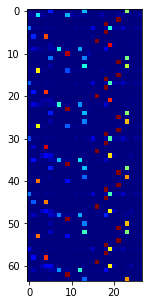

epochs: 21/100, train loss : 0.31948 train mse: 0.16263 train mae: 0.27536  validation loss: 0.32660 validation mse : 0.25279 validation mae: 0.36565
epochs: 22/100, train loss : 0.31229 train mse: 0.16120 train mae: 0.27490  validation loss: 0.32240 validation mse : 0.23427 validation mae: 0.35146
epochs: 23/100, train loss : 0.30557 train mse: 0.15786 train mae: 0.27330  validation loss: 0.31888 validation mse : 0.24136 validation mae: 0.35776
epochs: 24/100, train loss : 0.29921 train mse: 0.15291 train mae: 0.26988  validation loss: 0.31593 validation mse : 0.24824 validation mae: 0.36225
epochs: 25/100, train loss : 0.29322 train mse: 0.14948 train mae: 0.26764  validation loss: 0.31312 validation mse : 0.24548 validation mae: 0.36065
epochs: 26/100, train loss : 0.28758 train mse: 0.14651 train mae: 0.26579  validation loss: 0.31082 validation mse : 0.25354 validation mae: 0.36507
epochs: 27/100, train loss : 0.28224 train mse: 0.14330 train mae: 0.26343  validation loss: 0.30881

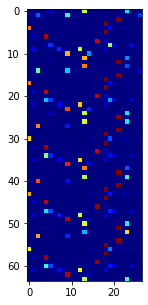

epochs: 31/100, train loss : 0.26428 train mse: 0.14711 train mae: 0.26712  validation loss: 0.30115 validation mse : 0.23772 validation mae: 0.36009
epochs: 32/100, train loss : 0.26058 train mse: 0.14576 train mae: 0.26542  validation loss: 0.29953 validation mse : 0.24936 validation mae: 0.36706
epochs: 33/100, train loss : 0.25693 train mse: 0.14027 train mae: 0.26041  validation loss: 0.29822 validation mse : 0.25637 validation mae: 0.37019
epochs: 34/100, train loss : 0.25329 train mse: 0.13295 train mae: 0.25502  validation loss: 0.29703 validation mse : 0.25754 validation mae: 0.37071
epochs: 35/100, train loss : 0.24975 train mse: 0.12953 train mae: 0.25218  validation loss: 0.29596 validation mse : 0.25974 validation mae: 0.37309
epochs: 36/100, train loss : 0.24634 train mse: 0.12714 train mae: 0.25009  validation loss: 0.29505 validation mse : 0.26298 validation mae: 0.37625
epochs: 37/100, train loss : 0.24306 train mse: 0.12495 train mae: 0.24803  validation loss: 0.29428

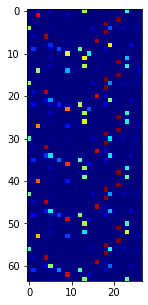

epochs: 41/100, train loss : 0.23112 train mse: 0.11830 train mae: 0.24138  validation loss: 0.29219 validation mse : 0.27632 validation mae: 0.38539
epochs: 42/100, train loss : 0.22840 train mse: 0.11686 train mae: 0.23982  validation loss: 0.29188 validation mse : 0.27929 validation mae: 0.38774
epochs: 43/100, train loss : 0.22578 train mse: 0.11577 train mae: 0.23867  validation loss: 0.29143 validation mse : 0.27245 validation mae: 0.38504
epochs: 44/100, train loss : 0.22324 train mse: 0.11427 train mae: 0.23689  validation loss: 0.29088 validation mse : 0.26748 validation mae: 0.38352
epochs: 45/100, train loss : 0.22079 train mse: 0.11278 train mae: 0.23512  validation loss: 0.29030 validation mse : 0.26482 validation mae: 0.38253
epochs: 46/100, train loss : 0.21842 train mse: 0.11176 train mae: 0.23379  validation loss: 0.28986 validation mse : 0.26970 validation mae: 0.38611
epochs: 47/100, train loss : 0.21612 train mse: 0.11053 train mae: 0.23224  validation loss: 0.28949

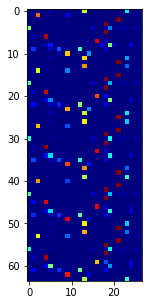

epochs: 51/100, train loss : 0.20763 train mse: 0.10672 train mae: 0.22757  validation loss: 0.28818 validation mse : 0.27145 validation mae: 0.38779
epochs: 52/100, train loss : 0.20567 train mse: 0.10581 train mae: 0.22627  validation loss: 0.28793 validation mse : 0.27495 validation mae: 0.38975
epochs: 53/100, train loss : 0.20382 train mse: 0.10737 train mae: 0.22746  validation loss: 0.28712 validation mse : 0.24480 validation mae: 0.36944
epochs: 54/100, train loss : 0.20211 train mse: 0.11148 train mae: 0.23323  validation loss: 0.28671 validation mse : 0.26518 validation mae: 0.37942
epochs: 55/100, train loss : 0.20088 train mse: 0.13471 train mae: 0.25539  validation loss: 0.28605 validation mse : 0.25073 validation mae: 0.37411
epochs: 56/100, train loss : 0.19940 train mse: 0.11813 train mae: 0.23934  validation loss: 0.28541 validation mse : 0.24995 validation mae: 0.37369
epochs: 57/100, train loss : 0.19791 train mse: 0.11446 train mae: 0.23515  validation loss: 0.28472

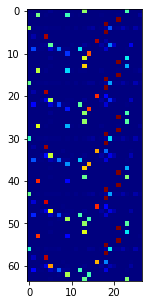

epochs: 61/100, train loss : 0.19185 train mse: 0.10267 train mae: 0.22235  validation loss: 0.28232 validation mse : 0.24577 validation mae: 0.37246
epochs: 62/100, train loss : 0.19039 train mse: 0.10154 train mae: 0.22091  validation loss: 0.28167 validation mse : 0.24210 validation mae: 0.37062
epochs: 63/100, train loss : 0.18897 train mse: 0.10056 train mae: 0.21952  validation loss: 0.28097 validation mse : 0.23762 validation mae: 0.36822
epochs: 64/100, train loss : 0.18757 train mse: 0.09951 train mae: 0.21817  validation loss: 0.28028 validation mse : 0.23718 validation mae: 0.36817
epochs: 65/100, train loss : 0.18620 train mse: 0.09859 train mae: 0.21684  validation loss: 0.27964 validation mse : 0.23812 validation mae: 0.36882
epochs: 66/100, train loss : 0.18486 train mse: 0.09771 train mae: 0.21565  validation loss: 0.27899 validation mse : 0.23723 validation mae: 0.36820
epochs: 67/100, train loss : 0.18355 train mse: 0.09701 train mae: 0.21459  validation loss: 0.27842

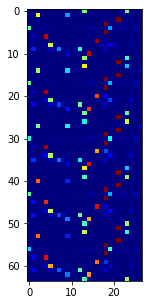

epochs: 71/100, train loss : 0.17861 train mse: 0.09487 train mae: 0.21133  validation loss: 0.27620 validation mse : 0.23984 validation mae: 0.36862
epochs: 72/100, train loss : 0.17744 train mse: 0.09433 train mae: 0.21049  validation loss: 0.27568 validation mse : 0.23867 validation mae: 0.36766
epochs: 73/100, train loss : 0.17629 train mse: 0.09374 train mae: 0.20968  validation loss: 0.27525 validation mse : 0.24447 validation mae: 0.37244
epochs: 74/100, train loss : 0.17517 train mse: 0.09320 train mae: 0.20880  validation loss: 0.27481 validation mse : 0.24283 validation mae: 0.37065
epochs: 75/100, train loss : 0.17407 train mse: 0.09255 train mae: 0.20786  validation loss: 0.27437 validation mse : 0.24147 validation mae: 0.37020
epochs: 76/100, train loss : 0.17299 train mse: 0.09223 train mae: 0.20736  validation loss: 0.27388 validation mse : 0.23727 validation mae: 0.36669
epochs: 77/100, train loss : 0.17194 train mse: 0.09171 train mae: 0.20659  validation loss: 0.27341

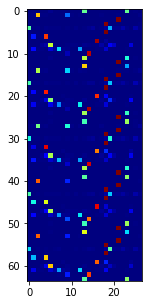

epochs: 81/100, train loss : 0.16797 train mse: 0.09074 train mae: 0.20492  validation loss: 0.27128 validation mse : 0.22888 validation mae: 0.35888
epochs: 82/100, train loss : 0.16702 train mse: 0.08999 train mae: 0.20391  validation loss: 0.27076 validation mse : 0.22821 validation mae: 0.35847
epochs: 83/100, train loss : 0.16608 train mse: 0.08939 train mae: 0.20327  validation loss: 0.27026 validation mse : 0.22933 validation mae: 0.35909
epochs: 84/100, train loss : 0.16517 train mse: 0.08888 train mae: 0.20254  validation loss: 0.26974 validation mse : 0.22659 validation mae: 0.35726
epochs: 85/100, train loss : 0.16426 train mse: 0.08839 train mae: 0.20184  validation loss: 0.26923 validation mse : 0.22624 validation mae: 0.35698
epochs: 86/100, train loss : 0.16338 train mse: 0.08816 train mae: 0.20134  validation loss: 0.26871 validation mse : 0.22458 validation mae: 0.35470
epochs: 87/100, train loss : 0.16253 train mse: 0.08970 train mae: 0.20349  validation loss: 0.26839

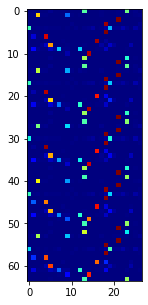

epochs: 91/100, train loss : 0.15930 train mse: 0.08717 train mae: 0.19984  validation loss: 0.26694 validation mse : 0.23164 validation mae: 0.35845
epochs: 92/100, train loss : 0.15851 train mse: 0.08641 train mae: 0.19898  validation loss: 0.26654 validation mse : 0.22990 validation mae: 0.36076
epochs: 93/100, train loss : 0.15773 train mse: 0.08593 train mae: 0.19837  validation loss: 0.26606 validation mse : 0.22241 validation mae: 0.35316
epochs: 94/100, train loss : 0.15696 train mse: 0.08574 train mae: 0.19798  validation loss: 0.26562 validation mse : 0.22455 validation mae: 0.35486
epochs: 95/100, train loss : 0.15621 train mse: 0.08526 train mae: 0.19737  validation loss: 0.26518 validation mse : 0.22331 validation mae: 0.35342
epochs: 96/100, train loss : 0.15547 train mse: 0.08502 train mae: 0.19698  validation loss: 0.26479 validation mse : 0.22773 validation mae: 0.35653
epochs: 97/100, train loss : 0.15473 train mse: 0.08443 train mae: 0.19621  validation loss: 0.26439

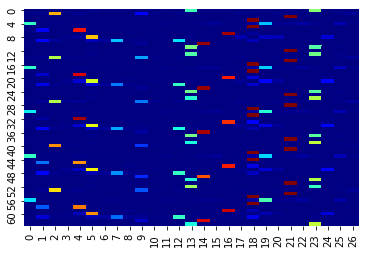

In [20]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}.gif', paths, fps=5)

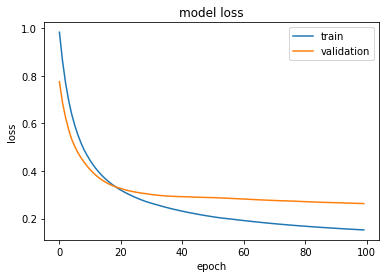

In [23]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [22]:
for i in range(10, 101 ,10) :
    model.load_weights(f"../data/model_weights/model_100_1560_806_cluster_0/model_{i}.pth")
    X_test, y_test = preprocessor.transform(test_data.values)
    scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

    print(f"Model MAE : {scores}")

    # Predict
    y_pred,_ = model.predict(X_test)
    y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
    comparison = np.hstack([y_pred, y_test])
    print(np.mean(np.abs(y_test - y_pred)))

Model MAE : 0.6854069232940674
13774.688549259461
Model MAE : 0.6854069232940674
11198.725583514268
Model MAE : 0.6854069232940674
11156.962270277605
Model MAE : 0.6854069232940674
11524.070856515586
Model MAE : 0.6854069232940674
11203.516155082003
Model MAE : 0.6854069232940674
10636.950398258181
Model MAE : 0.6854069232940674
9712.199221173232
Model MAE : 0.6854069232940674
9106.729922311182
Model MAE : 0.6854069232940674
9012.802959735576
Model MAE : 0.6854069232940674
8772.589099817773


In [24]:
X_test, y_test = preprocessor.transform(test_data.values)
model.load_weights(f"../data/model_weights/model_100_1560_806_cluster_0/model_100.pth")
y_pred,_ = model.predict(X_test)
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
comparison = np.hstack([y_pred, y_test])
print(np.mean(np.abs(y_test - y_pred)))

8772.589099817773


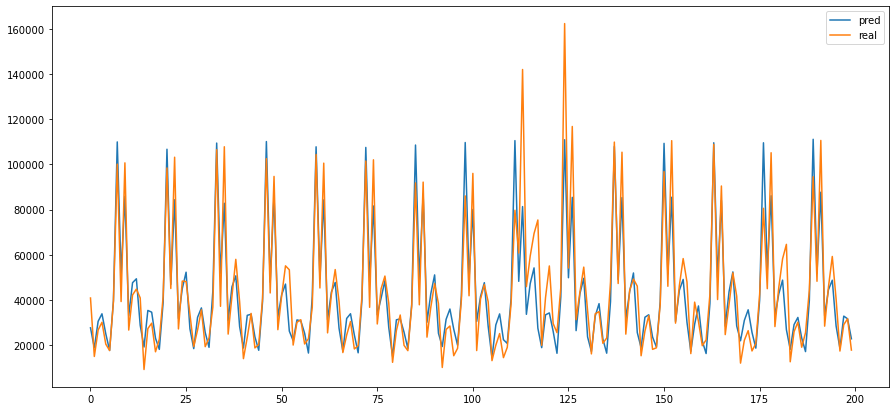

In [25]:
plt.figure(figsize=(15,7))
plt.plot(comparison[200:400])
plt.legend(['pred','real'])
plt.show()

In [26]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [27]:
final_dong_list = final_test_data.읍면동.unique()
final_test_data.drop(columns = '읍면동', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
final_test_data = final_test_data.set_index(['일자'])

In [29]:
a = scaler.transform(final_test_data)

In [30]:
np.asarray([a]).shape

(1, 1560, 27)

In [31]:
y_pred,_ = model.predict(np.asarray([a]))

In [32]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [33]:
y_pred

array([[ 54683.855 ],
       [107501.9   ],
       [ 49520.37  ],
       [ 42404.312 ],
       [ 55170.76  ],
       [ 23799.004 ],
       [ 12634.999 ],
       [ 33608.14  ],
       [ 36554.33  ],
       [ 19380.193 ],
       [ 26780.771 ],
       [ 51274.484 ],
       [114328.74  ],
       [ 54952.516 ],
       [108070.98  ],
       [ 49986.855 ],
       [ 43069.84  ],
       [ 53776.566 ],
       [ 24496.11  ],
       [ 13298.565 ],
       [ 34478.266 ],
       [ 35603.695 ],
       [ 22785.87  ],
       [ 26064.012 ],
       [ 51604.887 ],
       [114528.414 ],
       [ 54464.29  ],
       [109136.17  ],
       [ 52065.234 ],
       [ 43514.38  ],
       [ 53142.27  ],
       [ 23825.559 ],
       [ 13163.71  ],
       [ 34967.707 ],
       [ 37457.223 ],
       [ 19771.219 ],
       [ 25511.87  ],
       [ 51251.176 ],
       [114942.375 ],
       [ 54050.004 ],
       [108574.43  ],
       [ 48208.68  ],
       [ 42454.656 ],
       [ 54842.977 ],
       [ 25490.74  ],
       [ 1

In [34]:
final_test_data = data[-look_back_window:]

In [35]:
list(final_dong_list)

['대륜동',
 '동홍동',
 '삼도2동',
 '서홍동',
 '성산읍',
 '영천동',
 '예래동',
 '용담1동',
 '이도1동',
 '이호동',
 '정방동',
 '중앙동',
 '화북동']

In [36]:
final_dong_cluster_0 = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [37]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_0,np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [38]:
final_result[final_result['7_8월예측값'].astype('float') < 0 ] #음수값이 있나 확인

,읍면동,7_8월예측값


In [39]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_final_result.csv', encoding = 'cp949', index = False)